In [1]:
import glob

import pandas as pd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from unseen import fileio

## Obs

In [2]:
agcd_files = glob.glob('/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_month*.nc')
agcd_files.sort()
agcd_files

['/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1900.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1901.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1902.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1903.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1904.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1905.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1906.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1907.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1908.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthly_1909.nc',
 '/g/data/zv2/agcd/v2/precip/total/r005/01month/agcd_v2_precip_total_r005_monthl

In [26]:
agcd_ds = fileio.open_dataset(agcd_files,
                              variables=['pr'],
                              shapefile='australia.zip',
                              spatial_agg='mean',
                              time_freq='A-DEC',
                              time_agg='sum',
                              input_freq='M',
                              metadata_file='../../config/dataset_agcd_monthly.yml',
                              complete_time_agg_periods=True)

In [27]:
agcd_ds

<xarray.Dataset>
Dimensions:  (region: 1, time: 121)
Coordinates:
  * time     (time) object 1900-12-31 00:00:00 ... 2020-12-31 00:00:00
  * region   (region) int64 0
Data variables:
    pr       (time, region) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/33)
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    geospatial_lon_min:        111.975
    geospatial_lon_max:        156.275
    time_coverage_start:       1900-01-01T00:00:00
    date_created:              2020-08-27T21:49:15.867624
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-14 00:36:44
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    history:

In [35]:
agcd_ds = agcd_ds.squeeze(drop=True)
agcd_ds = agcd_ds.dropna('time')

In [36]:
agcd_ds

<xarray.Dataset>
Dimensions:  (time: 120)
Coordinates:
  * time     (time) object 1900-12-31 00:00:00 ... 2019-12-31 00:00:00
Data variables:
    pr       (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    geospatial_lat_min:        -44.525
    geospatial_lat_max:        -9.975
    geospatial_lon_min:        111.975
    geospatial_lon_max:        156.275
    time_coverage_start:       1900-01-01T00:00:00
    date_created:              2020-08-27T21:49:15.867624
    ...                        ...
    licence:                   Data Licence: The grid data files in this AGCD...
    description:               This AGCD data is a snapshot of the operationa...
    date_issued:               2020-12-14 00:36:44
    attribution:               Data should be cited as : Australian Bureau of...
    copyright:                 (C) Copyright Commonwealth of Australia 2020, ...
    history:

In [37]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [38]:
agcd_df

,pr
1900,379.649750
1901,408.575867
1902,323.070953
1903,524.036316
1904,510.047607
...,...
2015,440.201599
2016,534.991455
2017,499.601837
2018,410.467133


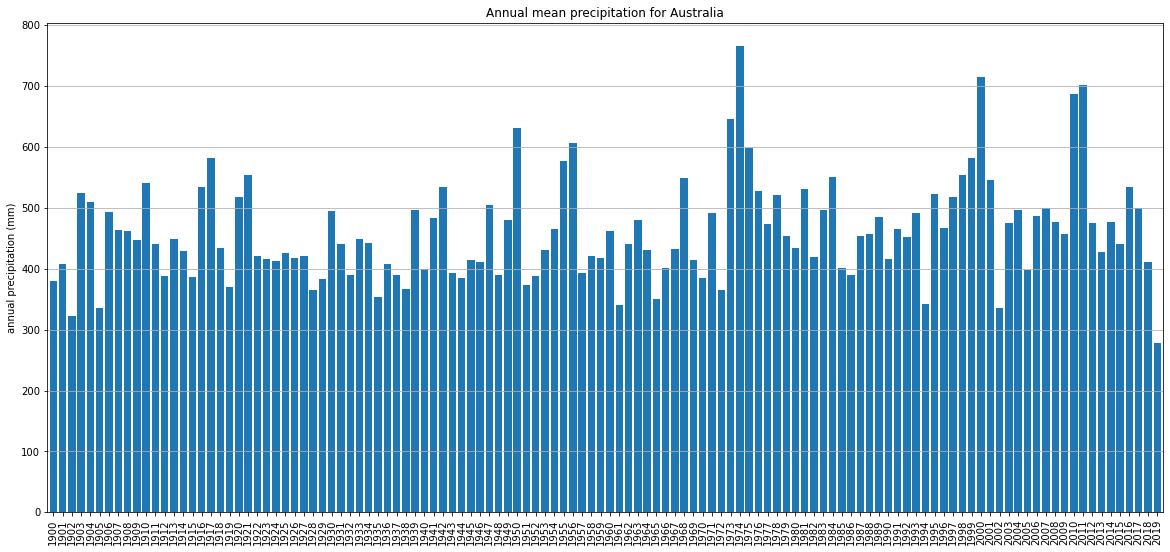

In [39]:
agcd_df['pr'].plot.bar(figsize=[20, 9], width=0.8)
#plt.axhline(mean_rainfall, color='0.5', linestyle='--')
plt.ylabel('annual precipitation (mm)')
plt.title(f'Annual mean precipitation for Australia')
plt.grid(axis='y')
plt.show()

2019 was the driest year on record for Australia. Do the example UNSEEN analysis on that.

## Model